## End-to-End Pipeline to Classify News Articles

### Exploring the data

In [11]:
# Importing libraries to be used in the project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import contractions
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

from sklearn.decomposition import NMF
from sklearn import svm
from sklearn import datasets, metrics
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

import pickle

In [742]:
# Initializations
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

stopWords = set(stopwords.words('English'))

In [562]:
# Loading the data
rawData = pd.read_csv('Project_1_dataset_01_01_2022.csv')

# Looking at raw data attributes
print("-------------Column names-------------\n \n", rawData.columns, '\n')

# Getting the unique leaf_label and root_label
print("-------------Unique leaf labels------------- \n", rawData['leaf_label'].unique(), '\n')
print("-------------Unique root labels------------- \n", rawData['root_label'].unique(), '\n')

print("Row samples: {}, features: {}, \n".format(rawData.shape[0], rawData.shape[1]))

print("-------------Viewing a few data points randomly-----------")
rawData.sample(5)


-------------Column names-------------
 
 Index(['Unnamed: 0', 'full_text', 'summary', 'keywords', 'publish_date',
       'authors', 'url', 'leaf_label', 'root_label'],
      dtype='object') 

-------------Unique leaf labels------------- 
 ['cricket' 'football' 'soccer' 'chess' '%22forest%20fire%22' 'flood'
 'earthquake' 'drought'] 

-------------Unique root labels------------- 
 ['sports' 'climate'] 

Row samples: 2072, features: 9, 

-------------Viewing a few data points randomly-----------


,Unnamed: 0,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
781,1840,Image via Kasparov Chess\n\nSpeaking to CNBC a...,Image via Kasparov ChessSpeaking to CNBC at th...,"['used', 'text', 'decision', 'axe', 'feature',...",2021-11-04 10:46:00,['Paul Hill'],https://www.neowin.net/news/garry-kasparov-say...,chess,sports
811,2024,"Nearly 3,000 fans packed Brooklyn’s historic K...","Nearly 3,000 fans packed Brooklyn’s historic K...","['smiths', 'hubert', 'healing', 'stop', 'brook...",NaN,[],https://www.essence.com/entertainment/janet-hu...,chess,sports
1079,2431,VIC Premier\n\nTwelve organisations across Vic...,VIC PremierTwelve organisations across Victori...,"['areas', 'club', 'local', 'community', 'bushf...",2021-10-07 04:42:16+00:00,[],https://www.miragenews.com/building-back-bette...,%22forest%20fire%22,climate
1657,3288,As the snow starts to settle in the Arizona hi...,A magnitude 3.0 earthquake in northern Arizona...,"['hits', 'earthquake', 'states', 'quakes', 'un...",2021-12-19 00:00:00,[],https://www.azcentral.com/story/news/local/ari...,earthquake,climate
1170,2323,"Meanwhile, Cal/OSHA also struggled with staffi...",One worker's storyCalifornia’s wildfire smoke ...,"['wildfire', 'days', 'chief', 'california', 'i...",NaN,[],https://www.kqed.org/news/11897789/california-...,%22forest%20fire%22,climate


Text(0, 0.5, 'Frequency of each root label')

<Figure size 432x288 with 0 Axes>

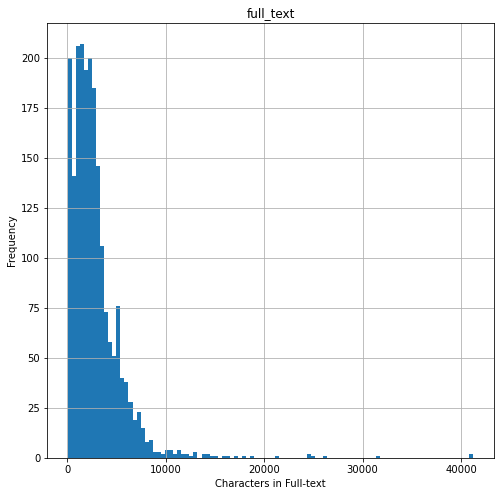

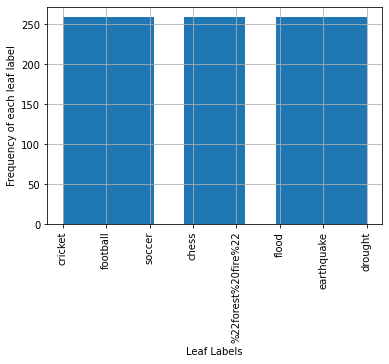

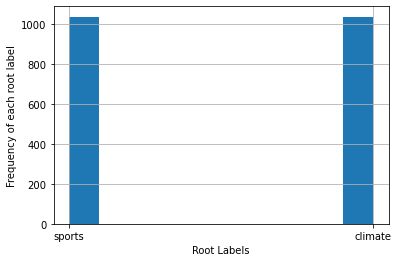

In [563]:
plt.figure()
pd.DataFrame(rawData['full_text'].apply(lambda x: len(x))).hist(bins=100, figsize= (8, 8))
plt.xlabel("Characters in Full-text")
plt.ylabel("Frequency")


plt.figure()
rawData['leaf_label'].hist(xrot=90)
plt.xlabel("Leaf Labels")
plt.ylabel("Frequency of each leaf label")


plt.figure()
rawData['root_label'].hist()
plt.xlabel("Root Labels")
plt.ylabel("Frequency of each root label")

### Question 1
<b>(a).</b>

    Row samples: 2072, features: 9

<b>(b)</b>. All three histograms are plotted in above cell.

<b>(c)</b>. For raw 'full-text' feature, we can see that there are a some outliers having a very large number of characters and quite a lot having extremely small number of characters. The data distribution of number of articles vs no. of characters can be roughly seen as a Gaussian Distribution.

For the histogram No. of articles vs Leaf labels, we can see that samples are evenly distributed into each leaf label (8 total labels) category with each label having around ~259 samples each.

For the histogram No. of articles vs Root labels, we can see that samples are evenly distributed into each root label (sports and climate) with each label having around ~ 1036 samples each.

In [564]:
# Seeding the random number generator

np.random.seed(42)
random.seed(42)

### Binary Classification of articles using only the feature "full_text"

In [565]:
#  Splitting the data into train and test with test_size as 20%
train, test = train_test_split(rawData, test_size=0.2)
print("--------- Train data Size: {}, Test data Size: {} ---------".format(len(train), len(test)))

--------- Train data Size: 1657, Test data Size: 415 ---------


### Question 2

Training dataset size: 1657

Test dataset size: 415


### Feature extraction

The feature which we are going to use is "full_text" which is neither cleaned nor it can be used to perform computations on it. We need some numerical representation of such data to perform classification.

In [816]:
#  Function to clean the raw HTML text
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r'http\S+', '', text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    texter = texter.strip()
    texter = contractions.fix(texter)
    texter = re.sub('''[!"#$%&'()*+,/;:-<=>?@[\]^_`{|}~-]''', '', texter)
    texter = texter.lower()
    texter = re.sub(' +', ' ', texter)
    if texter == "":
        texter = ""
    return texter

In [663]:
def get_pos_tags(nltkTag):
    firstChar = nltkTag[0]
    if firstChar == 'J':
        return wordnet.ADJ
    if firstChar == 'S':
        return wordnet.ADJ_SAT
    if firstChar == 'V':
        return wordnet.VERB
    if firstChar == 'N':
        return wordnet.NOUN
    if firstChar == 'R':
        return wordnet.ADV
    return wordnet.NOUN

def lemmatize(text):
    tokens = nltk.word_tokenize(text)
    posTags = nltk.pos_tag(tokens)
    tags = [get_pos_tags(w[1]) for w in posTags]
    lemmas = [lemmatizer.lemmatize(tokens[i], tags[i]) for i in range(0, len(tokens))]
    lemmas = ' '.join(lemmas)
    lemmas = re.sub(r'\w*\d\w*', '', lemmas)
    lemmas = re.sub('[.]', '', lemmas)
    lemmas = re.sub(' +', ' ', lemmas).strip()
    return lemmas

def stemmer(text):
    tokens = nltk.word_tokenize(text)
    stems = [ps.stem(tokens[i]) for i in range(0, len(tokens))]
    stems = ' '.join(stems)
    stems = re.sub(r'\w*\d\w*', '', stems)
    stems = re.sub('[.]', '', stems)
    stems = re.sub(' +', ' ', stems).strip()
    return stems

def preprocess(sample):
    sample = clean(sample)
    sample = sample.split('.')
    sample = [lemmatize(sentence) for sentence in sample]
    sample = '.'.join(sample)
    return sample

def preprocessStem(sample):
    sample = clean(sample)
    sample = sample.split('.')
    sample = [stemmer(sentence) for sentence in sample]
    sample = '.'.join(sample)
    return sample

def preprocessNoCompress(sample):
    sample = clean(sample)
    return sample

def preprocessNC(sample):
    sample = sample.split('.')
    sample = [lemmatize(sentence) for sentence in sample]
    sample = '.'.join(sample)
    return sample

def preprocessStemNC(sample):
    sample = sample.split('.')
    sample = [stemmer(sentence) for sentence in sample]
    sample = '.'.join(sample)
    return sample

def preprocessNoCompressNC(sample):
    return sample

In [664]:
# Feature Extraction using CountVectorizer and TF-IDF transformation using Pipeline.
featurePipeline = Pipeline([
    ('count', CountVectorizer(preprocessor=preprocess, stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True))
]).fit(train['full_text'])

In [569]:
#  TF-IDF processed train and test matrices.
train_tfidf = featurePipeline.transform(train['full_text'])
test_tfidf = featurePipeline.transform(test['full_text'])

print("--------- Training data TF-IDF Matrix size: {}--------".format(train_tfidf.shape))
print("--------- Testing data TF-IDF Matrix size: {}--------".format(test_tfidf.shape))

--------- Training data TF-IDF Matrix size: (1657, 9865)--------
--------- Testing data TF-IDF Matrix size: (415, 9865)--------


In [570]:
# Seeing some IDF values of words in training corpus
idf_Df = pd.DataFrame(pipe['tfidf'].idf_, index=pipe['count'].get_feature_names(),columns=["IDF_weights"])
idf_Df.sort_values(by=["IDF_weights"], ascending=False).sample(10)

,IDF_weights
dean,6.015472
occupy,5.417635
swim,6.803929
raging,7.027073
defensive,4.606705
bundesliga,6.803929
revenue,4.802449
brigade,6.216143
sandbag,6.803929
resonant,7.027073


In [571]:
# Getting TF-IDF vector representations of some of the documents in training corpus
trialData = train['full_text'].sample(5)
tfidf_trialData = pipe.transform(trialData)

### Question 3

<b>(a)</b>. 
<b>Pros of Lemmatization</b>:
1. Lemmatization tries to understand the context in which the word is used. Based on the context the word lemma can vary which is very useful if differentiating the context of two sentences having same words. 

2. Lemmatization can capture the semantic meaning of sentence.

<b>Cons of Lemmatization</b>:

1. Lemmatization requires a large corpus and well formed dictionaries to get the lemma of a word or change it based on the context and on the form(verb, noun, adverb etc) in which it is used in sentence. Stemming just uses the word and tries to find it's stem using language based rules by trimming from front or back of word.

2. Lemmatization process is slower in run-time compared to stemming.


<b>(b)</b>.
As we increase the min_df (minimum document frequency) the tf-idf size(columns) reduces since generally not all words are equally likely to be present in a corpus and thus words with lower frequencies (below min_df) in corpus are dropped and thus the representation vector for each sample also reduces.

<b>(c)<b>. 
It's better to remove stopwords after lemmatizing given one is using a complex lemmatizer which relies on context in which a word is used.

Punctuations should be removed before lemmatizing because most of the lemmatizers use a list of words as input and punctutations don't fall into a word category so they are quite useless. Some punctuations should be preprocessed and removed earlier like apostrophes in don't etc. This can be done via contractions.

Numbers can be removed before of after lemmatizing since they are just numerals and dont really have a lemma. Basically their form is unaltered even after lemmatizing.


<b>(d)</b>.
Training data TF-IDF Matrix size: (1657, 9865)
Testing data TF-IDF Matrix size: (415, 9865)

No. of columns: (k * 10^3) where k ~ 10

In [572]:
# Dimensionality Reduction

# Latent semantic indexing

# Singular values are already sorted.

def getSVD(n_comp, data):
    SVD = TruncatedSVD(n_components=n_comp, random_state=42)
    SVD.fit(data)
    return SVD

In [573]:
# NMF Non-negative Matrix Factorization
def getNMF(n_comp, data):
    NMFmodel = NMF(n_components=n_comp, init='random', random_state=42)
    NMFmodel.fit(data)
    return NMFmodel

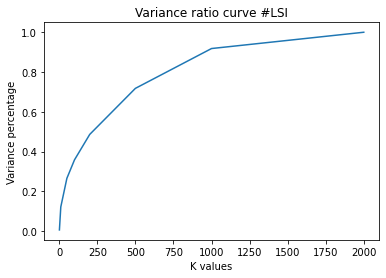

In [574]:
# Plotting variance graph
k_values = [1, 10, 50, 100, 200, 500, 1000, 2000]
variance_ratio = []
reconstructionErrors = []

for i in range(0, len(k_values)):
    SVD = getSVD(k_values[i], train_tfidf)
    variance_ratio.append(SVD.explained_variance_ratio_.sum())
    transformed = SVD.transform(train_tfidf)
    reconstruct = SVD.inverse_transform(transformed)
    reconstructionErrors.append(np.linalg.norm((train_tfidf.toarray() - reconstruct), 'fro') ** 2)
    
plt.plot(k_values, variance_ratio)
plt.xlabel("K values")
plt.ylabel("Variance percentage")
plt.title("Variance ratio curve #LSI")
plt.show()

In [575]:
# Fitting NMF for k = 50
k = 50
NMFdecomp = getNMF(k, train_tfidf)

In [576]:
# Reconstruction Errors
reconstructedLSIError = reconstructionErrors[2]
reconstructedNMFError = (NMFdecomp.reconstruction_err_)**2

print("---------- Reconstruction residual MSE error for LSI:: {} -----------".format(reconstructedLSIError))
print("---------- Reconstruction residual MSE error for NMF:: {} -----------".format(reconstructedNMFError))

---------- Reconstruction residual MSE error for LSI:: 1177.8659302458702 -----------
---------- Reconstruction residual MSE error for NMF:: 1197.1490559991569 -----------


### Question 4

<b>(a).</b>

The variance ration plot for LSI looks like a transient curve which increases exponentially when K is small and then saturates. It's a concave curve.
The plot's concavity suggests that projections along the initial singular vectors which correspond to largest eigen values capture most of the variance. The graph shows that principal 250 singular vectors capture around 60% of variance, and principal 1000 singular vectors capture around 92-95% of variance in training data.

<b>(b).</b>

Reconstruction residual MSE error for LSI:: 1177.8659302458702 </br>
Reconstruction residual MSE error for NMF:: 1197.1490559991569

Reconstruction residual MSE error for LSI is smaller compared to that from NMF.

The reconstruction error from NMF is smaller because NMF in particular tries to learn important features which represent the original data in a compressed format. Also given the data is textual data, NMF can easily represent the data vectors into smaller dimensions keeping the original features intact whereas PCA projects the original features onto best variance maintaing vectors thus loosing the originality.

## Binary Classification with choice of K

Choosing K to be 500 since it captures around 80% of variance also the number of data points then are almost 4 times to that of number of features.

### Using Support Vector Machines

In [577]:
k_feat = 500
train_labels = np.array((train['root_label'] == 'climate').astype('int'))
test_labels = np.array((test['root_label'] == 'climate').astype('int'))

SVDK500 = getSVD(k_feat, train_tfidf)
trainDataK500 = SVDK500.transform(train_tfidf)
testDataK500 = SVDK500.transform(test_tfidf)

In [578]:
#Hard Linear SVM
HardSVMModel = svm.SVC(kernel='linear', C = 1000)
HardSVMModel.fit(trainDataK500, train_labels)
predictionsHard = HardSVMModel.predict(testDataK500)

# Gamma = 100000
GammaSVMModel = svm.SVC(kernel='linear', C = 100000)
GammaSVMModel.fit(trainDataK500, train_labels)
predictionsGamma = GammaSVMModel.predict(testDataK500)

#Soft Linear SVM
SoftSVMModel = svm.SVC(kernel='linear', C = 0.0001)
SoftSVMModel.fit(trainDataK500, train_labels)
predictionsSoft = SoftSVMModel.predict(testDataK500)

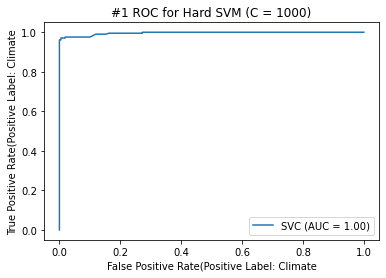

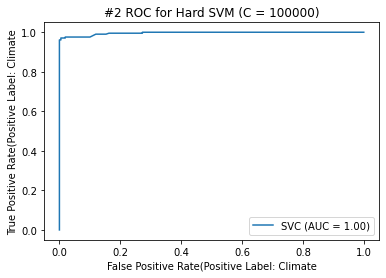

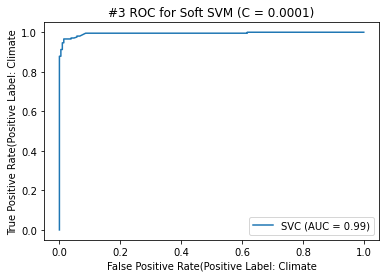

In [579]:
def getScores(y_true, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn) / len(y_true)
    precision = tp/ (tp + fp)
    recall = (tp) / (tp + fn)
    f1 = 2*precision*recall/(precision + recall)
    
    return {
        'confusion_matrix': confusion_matrix,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

svmScores = {
    'HardSMV': {
        'climate': {
            'scores': getScores(test_labels, predictionsHard)
        },
        'sports': {
            'scores': getScores(1 - test_labels, 1 - predictionsHard)
        }
    },
    'HighGammaSVM': {
        'climate': {
            'scores': getScores(test_labels, predictionsGamma)
        },
        'sports': {
            'scores': getScores(1 - test_labels, 1 - predictionsHard)
        }
    },
    'SoftSVM': {
        'climate': {
            'scores': getScores(test_labels, predictionsSoft)
        },
        'sports': {
            'scores': getScores(1 - test_labels, 1 - predictionsHard)
        }
    }
}

# Plotting ROCs for SVM
metrics.plot_roc_curve(HardSVMModel,testDataK500, test_labels)
plt.title("#1 ROC for Hard SVM (C = 1000)")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()
metrics.plot_roc_curve(GammaSVMModel,testDataK500, test_labels)
plt.title("#2 ROC for Hard SVM (C = 100000)")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()
metrics.plot_roc_curve(SoftSVMModel,testDataK500, test_labels)
plt.title("#3 ROC for Soft SVM (C = 0.0001)")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

In [580]:
# 5-Fold cross validation to find optimal gamma.
def avgKFoldError(clf, train, y):
    kf = KFold(n_splits=5)
    error = 0
    for train_idx, test_idx in kf.split(train):
        x_train, x_test = train[train_idx], train[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        clf.fit(x_train, y_train)
        predictions = clf.predict(x_test)
        error = error + sum(np.abs(predictions - y_test))
    
    return error / kf.n_splits

170.4 SVC(C=0.001, kernel='linear')
170.4 SVC(C=0.01, kernel='linear')
16.6 SVC(C=0.1, kernel='linear')
12.0 SVC(kernel='linear')
15.4 SVC(C=10.0, kernel='linear')
16.6 SVC(C=100.0, kernel='linear')
16.6 SVC(C=1000.0, kernel='linear')
16.6 SVC(C=10000.0, kernel='linear')
16.6 SVC(C=100000.0, kernel='linear')
16.6 SVC(C=1000000.0, kernel='linear')

------------Metrics for best SVM with C = 1.0 ------------- 

{'confusion_matrix': array([[209,   0],
       [  9, 197]]), 'accuracy': 0.9783132530120482, 'precision': 1.0, 'recall': 0.9563106796116505, 'f1': 0.9776674937965261}


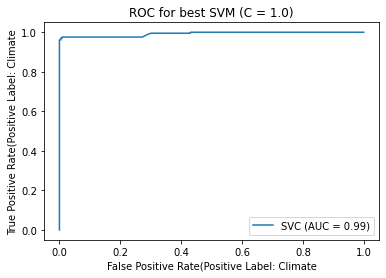

In [581]:
gammas = np.linspace(-3,6,10)
bestGamma = -1
minError = np.infty
bestSVM = None
for gamma in gammas:
    SVMk = svm.SVC(kernel='linear', C=(10**gamma))
    err = avgKFoldError(SVMk, trainDataK500, train_labels)
    print(err, SVMk)
    if err <= minError:
        minError = err
        bestGamma = 10**gamma
        bestSVM = SVMk

# Training best SVM
bestSVM.fit(trainDataK500, train_labels)
bestSVMPred = bestSVM.predict(testDataK500)

scores = getScores(test_labels, bestSVMPred)
print("\n------------Metrics for best SVM with C = {} ------------- \n".format(bestGamma))
print(scores)

metrics.plot_roc_curve(bestSVM, testDataK500, test_labels)
plt.title("ROC for best SVM (C = {})".format(bestGamma))
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

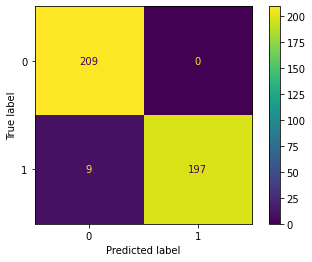

In [582]:
plot_confusion_matrix(bestSVM, testDataK500, test_labels)
plt.show()

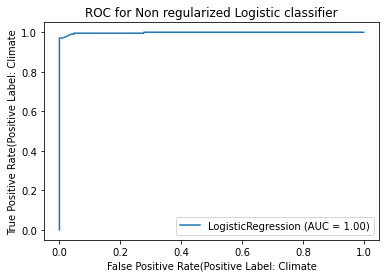


------------Metrics for Non regularized Logistic classifier------------- 

{'confusion_matrix': array([[209,   0],
       [  7, 199]]), 'accuracy': 0.983132530120482, 'precision': 1.0, 'recall': 0.9660194174757282, 'f1': 0.9827160493827161}


In [583]:
# Logistic classifier
# Setting C to be high thus making regularization term ~0
logisticNoReg = LogisticRegression(random_state=42, C=100000, max_iter=5000).fit(trainDataK500, train_labels)
logisticNoRegPred = logisticNoReg.predict(testDataK500)
logisticNoRegScores = getScores(test_labels, logisticNoRegPred)

# Plotting ROC for Non regularization Logistic classifier
metrics.plot_roc_curve(logisticNoReg, testDataK500, test_labels)
plt.title("ROC for Non regularized Logistic classifier")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

print("\n------------Metrics for Non regularized Logistic classifier------------- \n")
print(logisticNoRegScores)

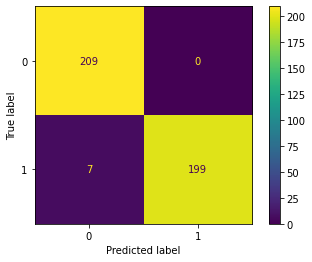

In [584]:
plot_confusion_matrix(logisticNoReg, testDataK500, test_labels)
plt.show()

Avg. no. of misclassification:  166.0 LogisticRegression(C=0.0001, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  166.0 LogisticRegression(C=0.001, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  166.0 LogisticRegression(C=0.01, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  31.0 LogisticRegression(C=0.1, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  15.2 LogisticRegression(max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  11.8 LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  12.0 LogisticRegression(C=100.0, max_iter=5000, penalty='l1', random_state=42

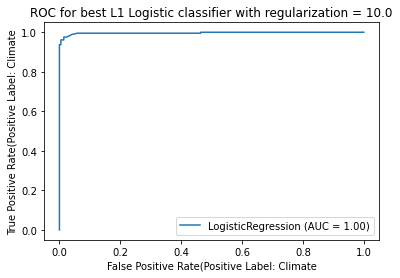

Avg. no. of misclassification:  57.2 LogisticRegression(C=0.0001, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  44.2 LogisticRegression(C=0.001, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  19.4 LogisticRegression(C=0.01, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  16.2 LogisticRegression(C=0.1, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  11.2 LogisticRegression(max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  10.6 LogisticRegression(C=10.0, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  12.8 LogisticRegression(C=100.0, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  14.4 LogisticRegression(C=1000.0, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  14.8 LogisticRegression(C=10000.0, max_iter

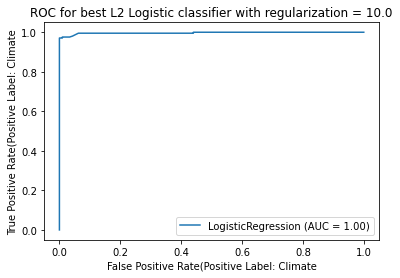

In [654]:
# Finding best regularization parameter for both L1 and L2 regularization for Logistic classifier
logRegs = np.linspace(-4,4,9)
bestRegL1 = -1
minL1Error = np.infty
bestL1Model = None
for reg in logRegs:
    clfLog = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, C=10**reg, max_iter=5000)
    err = avgKFoldError(clfLog, trainDataK500, train_labels)
    print("Avg. no. of misclassification: ", err, clfLog)
    if err <= minL1Error:
        minL1Error = err
        bestRegL1 = 10**reg
        bestL1Model = clfLog

# Training best L1 Logistic classifier
bestL1Model.fit(trainDataK500, train_labels)
bestL1Pred = bestL1Model.predict(testDataK500)

L1scores = getScores(test_labels, bestL1Pred)
print("\n------------Metrics for best L1 Logistic classifier with regularization = {}".format(bestRegL1))
print(L1scores)

metrics.plot_roc_curve(bestL1Model, testDataK500, test_labels)
plt.title("ROC for best L1 Logistic classifier with regularization = {}".format(bestRegL1))
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()


bestRegL2 = -1
minL2Error = np.infty
bestL2Model = None
for reg in logRegs:
    clfLog = LogisticRegression(penalty='l2', random_state=42, C=10**reg, max_iter=5000, solver='liblinear')
    err = avgKFoldError(clfLog, trainDataK500, train_labels)
    print("Avg. no. of misclassification: ", err, clfLog)
    if err <= minL2Error:
        minL2Error = err
        bestRegL2 = 10**reg
        bestL2Model = clfLog

# Training best L1 Logistic classifier
bestL2Model.fit(trainDataK500, train_labels)
bestL2Pred = bestL2Model.predict(testDataK500)

L2scores = getScores(test_labels, bestL2Pred)
print("\n------------Metrics for best L2 Logistic classifier with regularization = {}".format(bestRegL1))
print(L2scores)

metrics.plot_roc_curve(bestL2Model, testDataK500, test_labels)
plt.title("ROC for best L2 Logistic classifier with regularization = {}".format(bestRegL2))
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

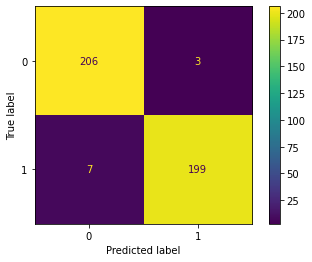

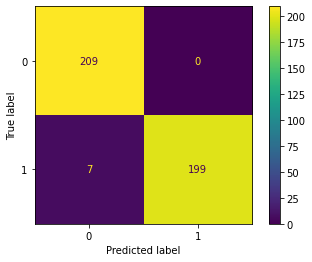

In [655]:
plot_confusion_matrix(bestL1Model, testDataK500, test_labels)
plt.show()

plot_confusion_matrix(bestL2Model, testDataK500, test_labels)
plt.show()

In [587]:
# Comparison b/w thre types of Logistic Classifiers.

# Best Non regularized classifier
print("---------- Non regularized Classifier details ---------- \n")
print(logisticNoReg, "\n")
print("----------- Scores ---------- \n")
print(logisticNoRegScores)

# Best L1 regularized classifier
print("---------- Best L1 regularized Classifier details ---------- \n")
print(bestL1Model, "\n")
print("----------- Scores ---------- \n")
print(L1scores)

# Best L2 regularized classifier
print("---------- Best L2 regularized Classifier details ---------- \n")
print(bestL2Model, "\n")
print("----------- Scores ---------- \n")
print(L2scores)

---------- Non regularized Classifier details ---------- 

LogisticRegression(C=100000, max_iter=5000, random_state=42) 

----------- Scores ---------- 

{'confusion_matrix': array([[209,   0],
       [  7, 199]]), 'accuracy': 0.983132530120482, 'precision': 1.0, 'recall': 0.9660194174757282, 'f1': 0.9827160493827161}
---------- Best L1 regularized Classifier details ---------- 

LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear') 

----------- Scores ---------- 

{'confusion_matrix': array([[206,   3],
       [  7, 199]]), 'accuracy': 0.9759036144578314, 'precision': 0.9851485148514851, 'recall': 0.9660194174757282, 'f1': 0.9754901960784313}
---------- Best L2 regularized Classifier details ---------- 

LogisticRegression(C=10.0, max_iter=5000, random_state=42) 

----------- Scores ---------- 

{'confusion_matrix': array([[209,   0],
       [  7, 199]]), 'accuracy': 0.983132530120482, 'precision': 1.0, 'recall': 0.96601941747

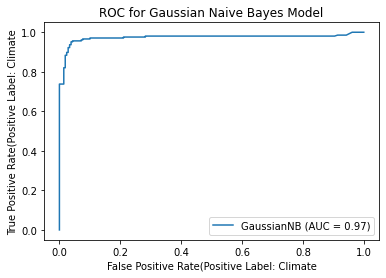


------------Metrics for Gaussian Naive Bayes Model---------

{'confusion_matrix': array([[172,  37],
       [  6, 200]]), 'accuracy': 0.8963855421686747, 'precision': 0.8438818565400844, 'recall': 0.970873786407767, 'f1': 0.9029345372460497}


In [588]:
# Gaussian Naive Bayes Model
GaussianNBModel = GaussianNB()
GaussianNBModel.fit(trainDataK500, train_labels)
gaussianNBPred = GaussianNBModel.predict(testDataK500)

metrics.plot_roc_curve(GaussianNBModel, testDataK500, test_labels)
plt.title("ROC for Gaussian Naive Bayes Model")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

gaussianNBScores = getScores(test_labels, gaussianNBPred)
print("\n------------Metrics for Gaussian Naive Bayes Model---------\n")
print(gaussianNBScores)

In [14]:
a = pd.read_csv('./resultsGridSearch.csv')

In [17]:
a.sort_values(by=['mean_test_score'], ascending=False)

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_count,param_dim_reduce,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
72,72,2.315673,0.042662,0.159835,0.006352,"LogisticRegression(C=10.0, max_iter=5000, pena...","CountVectorizer(min_df=3,\n pre...","TruncatedSVD(n_components=500, random_state=42)","{'clf': LogisticRegression(C=10.0, max_iter=50...",0.978916,0.975904,0.963746,0.972810,0.969789,0.972233,0.005224,1
97,97,9.268961,0.100465,2.012643,0.076325,"LogisticRegression(C=10.0, max_iter=5000, pena...","CountVectorizer(min_df=3,\n pre...","TruncatedSVD(n_components=500, random_state=42)","{'clf': LogisticRegression(C=10.0, max_iter=50...",0.981928,0.981928,0.960725,0.966767,0.966767,0.971623,0.008698,2
87,87,1.815008,0.021376,0.155370,0.006162,"LogisticRegression(C=10.0, max_iter=5000, pena...","CountVectorizer(min_df=5,\n pre...","TruncatedSVD(n_components=500, random_state=42)","{'clf': LogisticRegression(C=10.0, max_iter=50...",0.972892,0.978916,0.951662,0.981873,0.963746,0.969818,0.010991,3
27,27,1.973713,0.059857,0.183746,0.005624,SVC(kernel='linear'),"CountVectorizer(min_df=5,\n pre...","TruncatedSVD(n_components=500, random_state=42)","{'clf': SVC(kernel='linear'), 'count': CountVe...",0.978916,0.981928,0.954683,0.966767,0.963746,0.969208,0.010028,4
189,189,10.898173,0.775023,2.079957,0.087756,GaussianNB(),"CountVectorizer(min_df=3, preprocessor=<functi...","NMF(init='random', n_components=50, random_sta...","{'clf': GaussianNB(), 'count': CountVectorizer...",0.960843,0.981928,0.978852,0.963746,0.957704,0.968615,0.009851,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,220,0.251717,0.005095,0.051631,0.001998,GaussianNB(),"CountVectorizer(min_df=3,\n pre...","TruncatedSVD(n_components=5, random_state=42)","{'clf': GaussianNB(), 'count': CountVectorizer...",0.864458,0.852410,0.809668,0.897281,0.851964,0.855156,0.028100,236
230,230,8.030470,0.109228,2.013741,0.095850,GaussianNB(),"CountVectorizer(min_df=5,\n pre...","TruncatedSVD(n_components=5, random_state=42)","{'clf': GaussianNB(), 'count': CountVectorizer...",0.879518,0.864458,0.818731,0.861027,0.842900,0.853327,0.020855,237
200,200,8.319007,0.062501,2.080274,0.100514,GaussianNB(),"CountVectorizer(min_df=5, preprocessor=<functi...","TruncatedSVD(n_components=5, random_state=42)","{'clf': GaussianNB(), 'count': CountVectorizer...",0.879518,0.858434,0.818731,0.861027,0.839879,0.851518,0.020653,238
43,43,0.344645,0.054854,0.058195,0.001834,SVC(kernel='linear'),"CountVectorizer(min_df=3,\n pre...","NMF(init='random', n_components=5, random_stat...","{'clf': SVC(kernel='linear'), 'count': CountVe...",0.906627,0.855422,0.673716,0.903323,0.851964,0.838210,0.085398,239
